##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bildklassifikation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/TUBAF_Fruehjahrsakademie2026/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/TUBAF_Fruehjahrsakademie2026/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In diesem Tutorial werden Blumenbilder klassifiziert.

Es folgt den grundlegenden Machine Learning Schritten:

1. Daten betrachten und verstehen
2. Eingabe Pipeline erstellen
3. Model bauen
4. Model trainieren
5. Model testen
6. Model verbessern und den Prozess wiederholen

## Import TensorFlow und benötigte Bibliotheken

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2026-02-24 16:01:37.996533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-24 16:01:38.012019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-24 16:01:38.016337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-24 16:01:38.028053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-24 16:01:39.022428: W tensorflow/compiler/tf2

## Dataset downloaden und kennenlernen

Dieses Tutorial nutzt ein Dataset mit ca. 3,700 Fotos von Blumen. Das Datenset besteht aus fünf Unterverzeichnissen pro Klasse:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [9]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Jetzt steht eine Kopie des Datasets zur Verfügung. Insgesamt gibt es 3,670 Bilder:

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Hier einige Rosen:

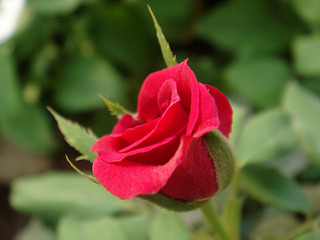

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### Aufgabe
Schaut in jedes der Unterverzeichnisse und schaut euch ein paar der Blumenbilder an.
Nutzt dazu untenstehenden Code.  

Die Unterverzeichnisse sind:
```
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```
Der Index der Liste gibt das entsprechende Bild an.

Fällt euch was auf?


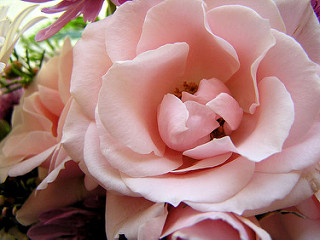

In [12]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[-1]))

# Laden der Daten mit Keras

Die Bilder müssen von der Festplatte geladen werden. Dabei hilft die `tf.keras.utils.image_dataset_from_directory` Methode.
Dies erzeugt aus einem Verzeichnis voller Bilder ein `tf.data.Dataset` mit wenigen Codezeilen.

## Datenset anlegen

Parameter:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

80% der Bilder sollten für Training genutzt werden und die restlichen 20% zur Validierung.

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Die Klassenbezeichner finden sich im `class_names` attribute des Datensets. Diese entsprechen den Unterverzeichnisnamen .

In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Daten anzeigen

Hier die ersten neun Bilder der Datensets.

2026-02-24 16:06:06.140971: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


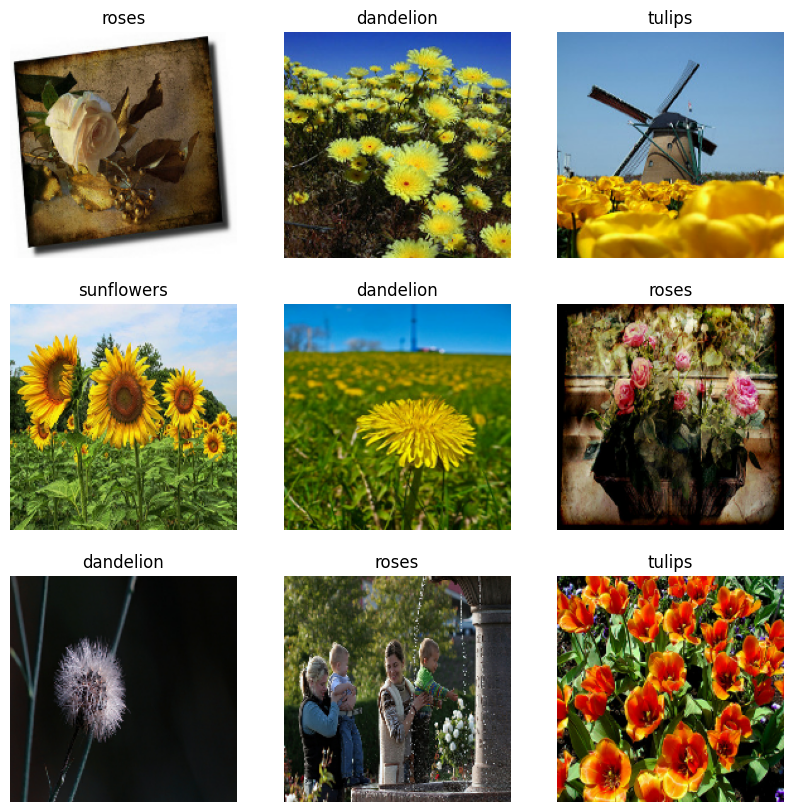

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Performance des Datensets anpassen

Die Puffergrössen müssen angepaßt werden um ein schnelles Laden zu gewährleisten.

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardisierung der Daten

Die Rot/Grün/Blau Kanäle der Bilder sind im Bereich von `[0, 255]`.
Das ist nicht ideal für ein Neuronales Netzwerk. Für dieses sollte der Input klein sein.

Wir werden die Werte standardisieren auf einen Interval von `[0, 1]` mittels der Methode `tf.keras.layers.Rescaling`:

In [19]:
normalization_layer = layers.Rescaling(1./255)

Es gibt zwei Möglichkeiten diesen Layer anzuwenden. Wir können ihn direkt auf die Daten anwenden mit `Dataset.map`.

Oder wir können ihn in unser Model einbauen, was wir weiter unten tun werden.

# Create the model

The [Sequential](../../guide/keras/sequential_model.ipynb) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

## Convolutions

[Ein Blick in die Netze](https://microscope.openai.com/models)


In [21]:
num_classes = 5

model = Sequential([
  layers.InputLayer(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255 ),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren des Models



In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Übersicht

Mit der `Model.summary` Methode können wir uns alle Layer des Models anschauen:

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Training des Models

In [24]:
epochs=6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - accuracy: 0.4071 - loss: 1.4111 - val_accuracy: 0.5845 - val_loss: 1.0709
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.6303 - loss: 0.9380 - val_accuracy: 0.6362 - val_loss: 0.9306
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 285ms/step - accuracy: 0.7239 - loss: 0.7213 - val_accuracy: 0.6035 - val_loss: 0.9756
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - accuracy: 0.8194 - loss: 0.5252 - val_accuracy: 0.6362 - val_loss: 0.9983
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 290ms/step - accuracy: 0.8890 - loss: 0.3110 - val_accuracy: 0.6580 - val_loss: 1.0495
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.9407 - loss: 0.1872 - val_accuracy: 0.6526 - val_loss: 1.2174
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 290ms/step - accuracy: 0.9789 - loss: 0.0688 - val_accuracy: 0.6553 - val_loss: 1.3958
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 292ms/step - accuracy: 0.9861 - loss: 0.0651 - val_accu

## Anzeigen der Trainingsresultate

Erstellen eines Diagramms auf dem Trainingsset und dem Validierungsset:

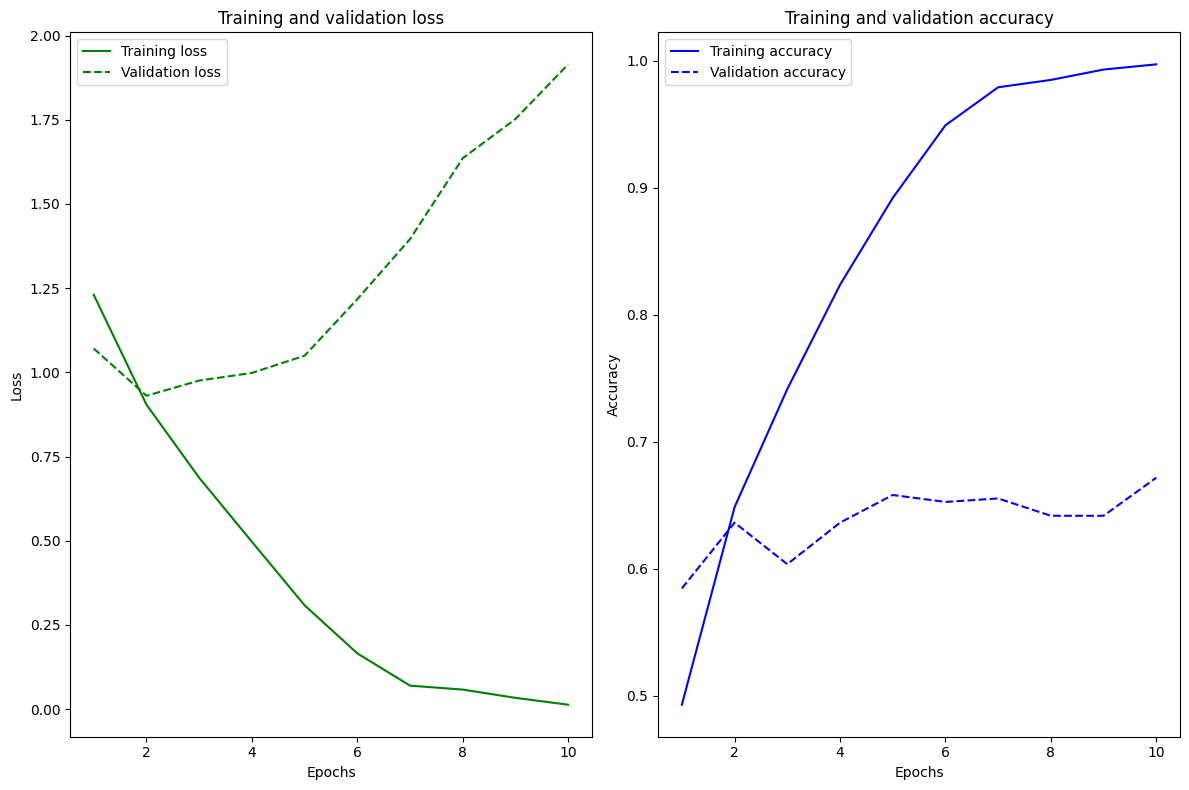

In [25]:
import matplotlib.pyplot as plt

def plot_acc_val(history_dict):

    def plot_subplot(type, axis, color, train, val):
        axis.plot(epochs, train, '%s'%color, label='Training %s'%type)
        axis.plot(epochs, val, '%s--'%color, label='Validation %s'%type)
        axis.set_title("Training and validation %s"%type)
        axis.set_xlabel('Epochs')
        axis.set_ylabel(type.capitalize())
        axis.legend()
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict.get('accuracy', history_dict.get('acc'))
    val_accuracy = history_dict.get('val_accuracy', history_dict.get('val_acc'))
    epochs = range(1, len(loss) + 1)

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plotting the training and validation loss
    plot_subplot('loss', ax1, 'g', loss, val_loss)

    # Plotting the training and validation accuracy
    if accuracy is not None and val_accuracy is not None:
        plot_subplot('accuracy', ax2, 'b', accuracy, val_accuracy)

    plt.tight_layout()
    plt.show()

plot_acc_val(history.history)


Die Plots zeigen dass die Trainingsgenauigkeit und die Validierungsgenauigkeit sich um Größeneinheiten unterscheiden. Und die Genauigkeit des Modells liegt lediglich bei 60%.

Was ist also schief gelaufen und was können wir dagegen tun?

## Overfitting

Im obigen Diagramm wächst die Trainingsgenauigkeit Linear, aber die Validierungsgenauigkeit bricht bei ca. 60% ab.
Ebenso ist die Differenz zwischen Training und Validierung sehr groß. Dies ist ein Zeichen für [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Bei kleinen Mengen an Trainingsbeispielen lernen die Modelle manchmal unerwünschte Details oder Hintergrundrauschen der Trainingsbilder. Wenn dies zuviel passiert hat das einen negativen Einfluss auf die Performance.
Diese Overfitting bedeutet das das Model Schwierigkeiten hat sich auf ein neues Dataset zu Generalisieren.

Wir werden hier *data augmentation* nutzen und *Dropout* Layer zeigen.

## Data augmentation

Overfitting passiert generell when es zu wenige Trainingsbilder gibt.
Mit Data Augmentation werden aus alten Bildern neue Bilder generiert die geringfügig verändert werden um so in Summe aus wenigen Bildern mehr zu machen.

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.InputLayer(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Schauen wir uns einige der neuen Bilder an:

2026-02-24 16:12:55.819650: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


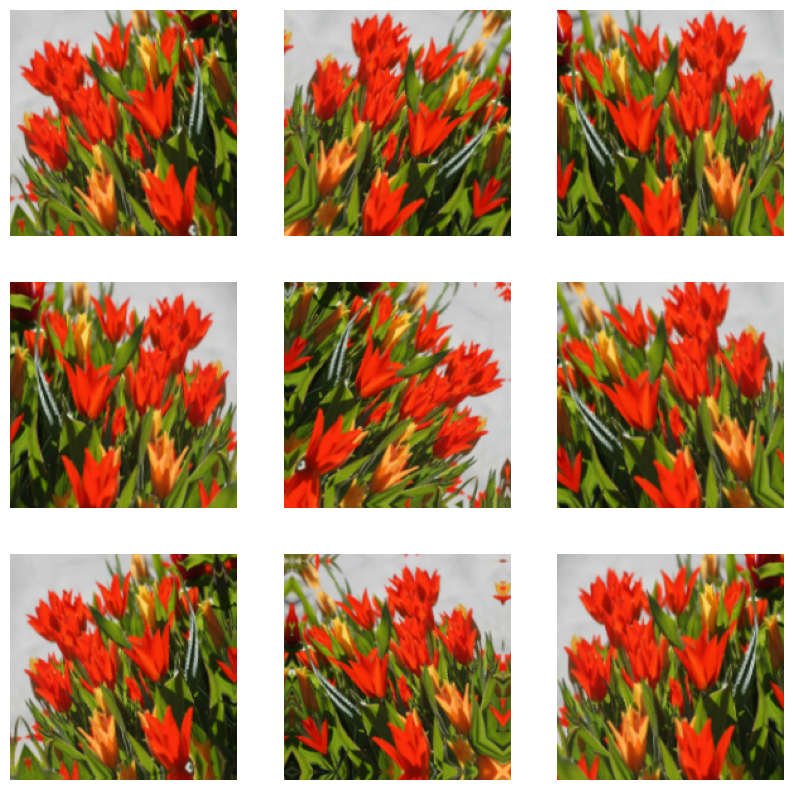

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Eine andere Technik um Overfitting zu vermeiden ist der [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) im Netzwerk.

Ein Dropoutlayer läßt zufällig einige Eingabe aus der Verarbeitung im Netzwerk fallen (die Aktivierung wird auf 0 gesetzt).
Bei dem Dropoutlayer kann man mit Kommazahlen die Prozentanzahl an ignorierten Eingaben einstellen (0.1=10% etc.).

Wir erzeugen jetzt ein neues Netzwerk mit  `tf.keras.layers.Dropout` Layern und werden das dann mit unseren data augmented Eingaben trainieren:

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren und trainieren des Models

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 6
history_imp = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 313ms/step - accuracy: 0.2947 - loss: 1.6553 - val_accuracy: 0.5409 - val_loss: 1.1241
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 300ms/step - accuracy: 0.5372 - loss: 1.1201 - val_accuracy: 0.6022 - val_loss: 0.9792
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.6224 - loss: 0.9865 - val_accuracy: 0.6594 - val_loss: 0.8818
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.6696 - loss: 0.8704 - val_accuracy: 0.6458 - val_loss: 0.8833
Epoch 5/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.6811 - loss: 0.8173 - val_accuracy: 0.6485 - val_loss: 0.8852
Epoch 6/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 297ms/step - accuracy: 0.6974 - loss: 0.7725 - val_accuracy: 0.6649 - val_loss: 0.8390


## Anzeigen der Trainingsergebnisse

Nachdem wir die Data Augmentation und den `tf.keras.layers.Dropout` Layer eingesetzt haben ist weniger overfitting als vorher zu erkennen. Ebenso ist die Genauigkeit des Trainings und des Validierungsdataset näher bei einander.

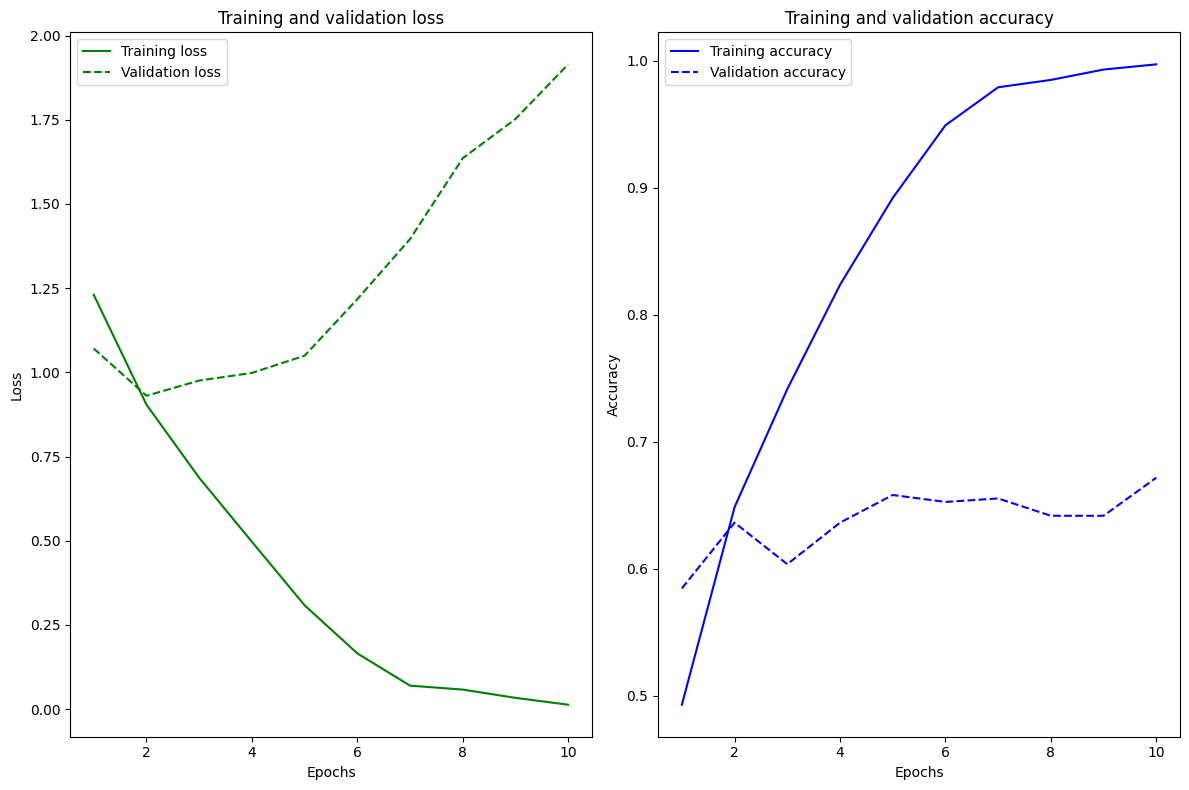

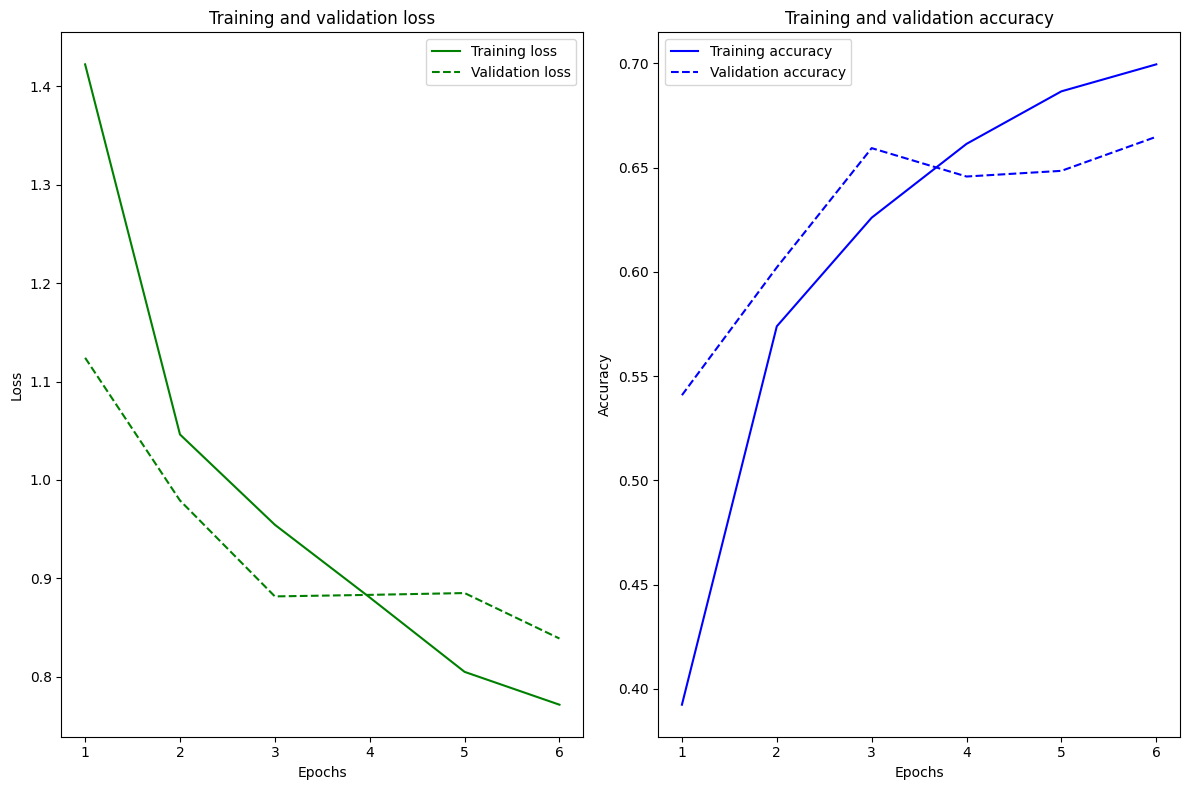

In [34]:
plot_acc_val(history.history)
plot_acc_val(history_imp.history)

## Vorhersage auf neuen Daten

Schlußendlich werden wir unser Model auf neuen Daten anwenden die nicht im Trainings oder Validierungs Set enthalten waren.
![](https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg)

In [35]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Dieses Bild gehört zu {} mit {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Dieses Bild gehört zu tulips mit 70.98 %.


### Experiment

Nutze untenstehenden Code um das Model anzupassen.
Wie hoch kannst du die Genauigkeit heben?  
  
Passe an:

- Data Augmentation (mögliche Funktionen werden weiter unten gezeigt)
- Parameter des Netzes
    - Layer (weitere hinzufügen, auch DropOut)
    - DropOut Parameter zwischen 0 und 1
    - Aktivierungsfunktion (relu, gelu, selu, sigmoid, etc.)
    - Layer Initializierung (he_normal, he_uniform, glorot_uniform, glorot_normal, random_normal)
    - Anzahl der Neuronen
    - Optimizers (adam, nadam, sgd)
---

#### Data Augmentation
Out of the `tf.keras.layers` package  

#### [RandomCrop](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_crop/) layer
mandatory:
- height
- width
#### [RandomFlip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/) layer
- optional:
- mode [horizontal", "vertical", or "horizontal_and_vertical"]
#### [RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_translation/) layer
mandatory:
- height_factor
- width_factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomRotation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/) layer
mandatory:
- factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/) layer
mandatory:
- height_factor
optional:
- width_factor
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomContrast](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/) layer
mandatory:
- factor
#### [RandomBrightness](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_brightness/) layer
mandatory:
- factor

In [ ]:
# RESET
tf.keras.backend.clear_session()


model_exp = Sequential([
    layers.InputLayer(shape=(img_height, img_width, 3)),
    # data augmentation part
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # normalization
    layers.Rescaling(1./255),
    # Neural Net
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Entscheidungsebene
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # letzen Layer nicht ändern, brauchen wir !
    layers.Dense(num_classes)
])


model_exp.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history_exp = model_exp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

plot_acc_val(history_exp.history)